# Demo

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    %%capture
    import os
    os.system("pip install objax wandb chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as np
from jax.config import config
# import chex
config.update("jax_enable_x64", False)

import numpy as onp
from functools import partial
import objax
import chex
from pprint import pprint

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss
from rbig_jax.transforms.parametric.mixture import MixtureGaussianCDF
from rbig_jax.transforms.logit import Logit
from rbig_jax.transforms.inversecdf import InverseGaussCDF
from rbig_jax.transforms.parametric import HouseHolder
from rbig_jax.transforms.base import CompositeTransform
from rbig_jax.models.gaussflow import GaussianizationFlow


# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Demo Data

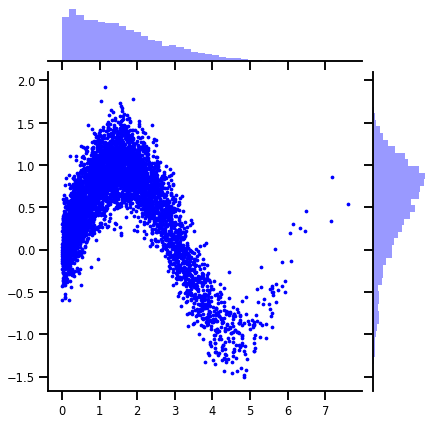

In [3]:
# %%wandb
# get data

n_samples = 5_000
n_features = 2


data = get_classic(n_samples)

# plot data
sns.jointplot(data[:, 0], data[:, 1], s=5, color='blue')

### Model

In [4]:
# model hyperparameters
n_components = 20
n_reflections = 2
n_features = data.shape[1]


n_layers = 4

transforms = []

for _ in range(n_layers):
    # mixture gaussian cdf distribution, f:[-inf,inf] -> [0,1]
    transforms.append(
        MixtureGaussianCDF(n_components=n_components)
    )
    # Logit quantile function, f:[0,1] -> [-inf,inf]
    transforms.append(
        Logit()
    )
    # orthogonal rotation layer
    transforms.append(
        HouseHolder(n_reflections=n_reflections)
    )
    
# compose all transformations into a single chain
# init_func = CompositeTransform(transforms)

# initialize base distribution
base_dist = jax.scipy.stats.norm

# initialize Model
gf_model = GaussianizationFlow(bijections=transforms, base_dist=base_dist)

### Initialize Parameters

In [5]:
seed = 123
flow_rng = jax.random.PRNGKey(seed)

params = gf_model.init_params(flow_rng, n_features)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


### Loss Function

In [6]:
def nll_loss(params, inputs):
    
    # negative log-likelihood
    return gf_model.score(params, inputs)

In [7]:
nll_loss(params, data)

DeviceArray(55.76823, dtype=float32)

### Optimizer

In [13]:
from jax.experimental import optimizers

lr = 1e-4
epochs = 1_000
batch_size = 128


opt_init, opt_update, get_params = optimizers.adam(step_size=lr)
opt_state = opt_init(params)

### Grad Step

In [14]:
X = np.array(data)

loss, grads_params = jax.value_and_grad(nll_loss)(params, X)

In [15]:
def step(i, opt_state, inputs):
    # get the parameters from the state
    params = get_params(opt_state)
    # calculate the loss AND the gradients
    loss, gradients = jax.value_and_grad(nll_loss)(params, inputs)
    
    # return loss AND new opt_state
    return loss, opt_update(i, gradients, opt_state)

# TO MAKE IT FAST
train_op = jax.jit(step)

### Optimization

In [16]:
import itertools
from jax import device_put
import tqdm
from jax import random


# initialize parameters
key = random.PRNGKey(123)
itercount = itertools.count()
permute_rng, rng = random.split(key)

train_data = np.array(data)

losses = list()

pbar = tqdm.trange(epochs)


with pbar:
    for i in pbar:

        # batch processing
        permute_rng, rng = random.split(rng)

        # randomly shuffle the data
        train_data = random.permutation(permute_rng, train_data)

        # Train
        avg_loss = []

        for batch_index in range(0, n_samples, batch_size):
            # compute loss
            loss, opt_state = train_op(
                next(itercount), 
                opt_state,
                train_data[batch_index:batch_index+batch_size],
            )
            
            
            # append batch
            avg_loss.append(float(loss))
        # average loss
        batch_loss = np.mean(np.stack(avg_loss))

        # Log losses
        losses.append(batch_loss)
        pbar.set_postfix({"loss": f"{batch_loss:.4f}"})

100%|██████████| 1000/1000 [03:22<00:00,  4.95it/s, loss=1.5200]


#### Losses

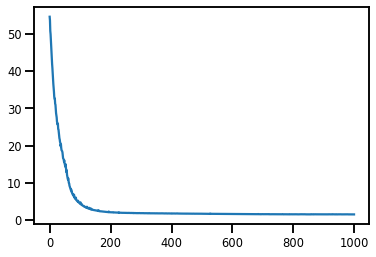

In [17]:
plt.plot(losses)

In [18]:
final_params = get_params(opt_state)

#### Forward Transformation

In [19]:
%%time
# forward transformation
z = gf_model.transform(final_params, data)

CPU times: user 818 ms, sys: 30 ms, total: 848 ms
Wall time: 628 ms


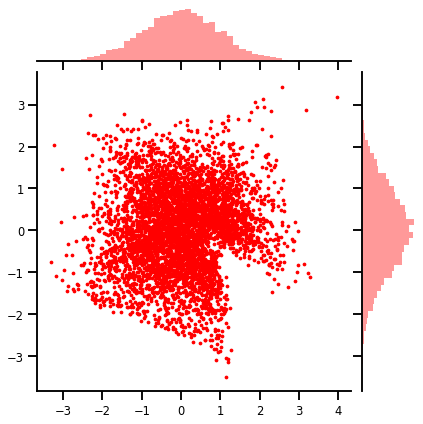

In [20]:
sns.jointplot(z[:, 0], z[:, 1], s=5, color='red')

#### Inverse Transformation

In [21]:
%%time
# inverse transformation
inverse_transform_jitted = jax.jit(gf_model.inverse_transform)
X_approx = inverse_transform_jitted(final_params, z)

CPU times: user 6.81 s, sys: 0 ns, total: 6.81 s
Wall time: 6.76 s


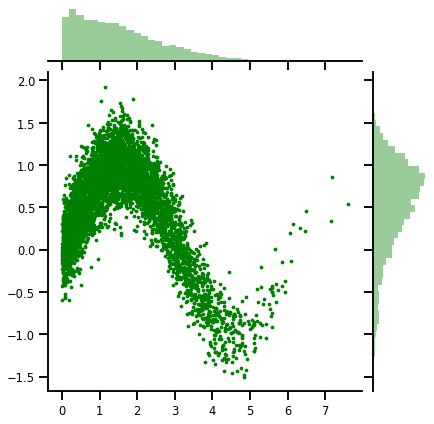

In [22]:
sns.jointplot(X_approx[:, 0], X_approx[:, 1], s=5, color='green')

### Application I - Generating Samples

In [23]:
%%time
# generate samples in the latent domain
n_gen_samples = 10_000

# inverse transformation
X_samples = gf_model.sample(rng=key, params=final_params, n_samples=n_gen_samples)

CPU times: user 2min 57s, sys: 3.37 s, total: 3min
Wall time: 22.9 s


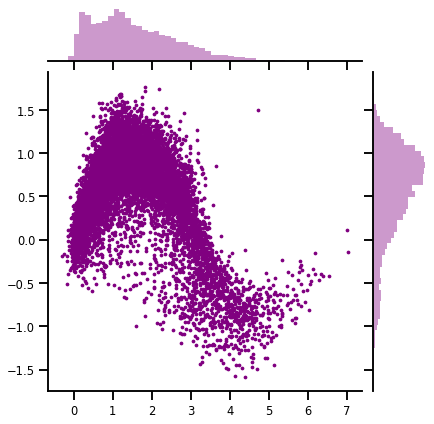

In [24]:
sns.jointplot(X_samples[:, 0], X_samples[:, 1], s=5, color='purple')

### Probability Density Estimation

In [25]:
%%time
# log probability
X_log_prob = gf_model.score_samples(final_params, np.array(data))

CPU times: user 710 ms, sys: 30.9 ms, total: 741 ms
Wall time: 534 ms


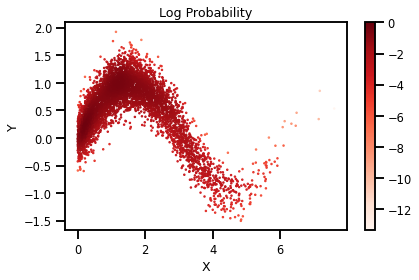

In [26]:
cmap = "Reds"
probs = X_log_prob
# probs = np.clip(probs, 0.0, 1.0)
probs = np.clip(probs, None, 0.0)
title = "Log Probability"

fig, ax = plt.subplots()
h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap=cmap, vmax=0.0)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

### Probability

In [27]:
ngrid = 500
buffer = 0.1
xline = np.linspace(data[:,0].min()-buffer, data[:,0].max()+buffer, ngrid)
yline = np.linspace(data[:,1].min()-buffer, data[:,1].max()+buffer, ngrid)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

In [28]:
%%time
# log probability
X_log_prob = gf_model.score_samples(final_params, np.array(xyinput))

CPU times: user 11.3 s, sys: 3.27 s, total: 14.5 s
Wall time: 5.21 s


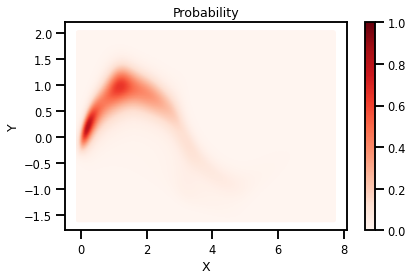

In [29]:
cmap = "Reds"
probs = np.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.scatter(xyinput[:, 0], xyinput[:, 1], s=1, c=probs,  cmap=cmap, vmin=0.0, vmax=1.0)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

### Negative Log-Likelihood

In [30]:
nll = gf_model.score(final_params, data)

print("Negative Log-Likelihood:", nll)

Negative Log-Likelihood: 1.5346112
